# Deep-LDA: Neural network-based discriminant CVs

Reference paper: _Bonati, Rizzi and Parrinello, [JCPL](https://pubs.acs.org/doi/10.1021/acs.jpclett.0c00535) (2020)_ [[arXiv]](https://arxiv.org/abs/2002.06562). 

### Introduction

The aim of this tutorial is to illustrate how we can design collective variables in a data-driven way, starting from local fluctuations of a set of physical descriptors in the metastable states. For applying these methods we will only need to have samples from different metastable states (typically obtained by MD simulations starting from e.g. reactants and products).

**Linear Discriminant Analysis**

To this extent, we resort to a statistical method called Linear Discriminant Analysis ([LDA](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)),. LDA searches for the linear projection $s=\bar{w}^T x$ of the input data $x$ such that the classes are maximally separated. This is measured by the so called Fisher's ratio:

$$\bar{w} = \text{argmax}_w {\frac{wS_b w^T}{wS_w w^T}}$$

where $S_b$ is the scatter matrix between the classes and $S_w$ the one between them. In the simple case of two classes (states) A and B these can be easily computed from the mean and covariance matrices of the data in the states:

$$S_w = \Sigma_A + \Sigma_B $$

$$S_b = (\mu_A-\mu_b)(\mu_A-\mu_b)^T $$

<center><img src="images/lda.png" width="300" /></center>

From a practical perspective, the vector $\bar{w}$ is found by solving the generalized eigenvalue problem: $S_b\bar{w} = v S_w \bar{w} $, where the eigenvalue $v$ measures the amount of separation between the states.

**Neural networks-based LDA**

Here we employ a non-linear generalization of LDA in which the mapping function is a neural network (NN). This greatly increases the discriminative power of the model, by learning a set of latent variables in which the metastable states are linearly separable. This is achieved by performing a nonlinear featurization of the inputs via a NN, and then LDA is applied to the outputs of the network. During the training, the parameters of the NN are optimized as to maximize the LDA eigenvalue $v$. In other words, we are transforming the input space in such a way that the discrimination between the states is maximal. 

Furthermore, in the context of enhanced sampling calculation, NNs lend themselves well because they provide a continuous and differentiable representation, and have no trouble in handling several descriptors. 

<center><img src="images/deeplda.png" width="800" /></center>

To achieve this we use the following loss function:

$$ \mathcal{L} = -v - \alpha \frac{1}{1+(\bar{s}^2-1)^2} $$

where the first term correspond to the maximization of the eigenvalue which describe the amount of separation of the two states and the second is a lorentzian regularization of the average value of the output CV, which keeps it close to 1.

Note that to stabilize the learning we also regularize the calculation of $S_w$ by adding the identity matrix multiplied by a parameter $\lambda$, as: $S_w '= S_w+\lambda\mathbb{1}$ . The two regularization parameters $\alpha$ and $\lambda$ are not independent, as the former affects the numerator of the Fisher's ratio above and the latter the denominator. Hence, in the following, we will choose only $\lambda$ and set $\alpha=\frac{2}{\lambda}$.

### Import

In [8]:
# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)

## LDA & Deep-LDA on Muller-Brown potential

#### Load MD data

In [3]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictionaryDataModule

n_states = 2
filenames = [ f"data/muller-brown/unbiased/state-{i}/COLVAR" for i in range(n_states) ]

# load dataset
dataset, df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'})

Class 0 dataframe shape:  (2001, 12)
Class 1 dataframe shape:  (2001, 12)

 - Loaded dataframe (4002, 12): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'labels']
 - Descriptors (4002, 2): ['p.x', 'p.y']


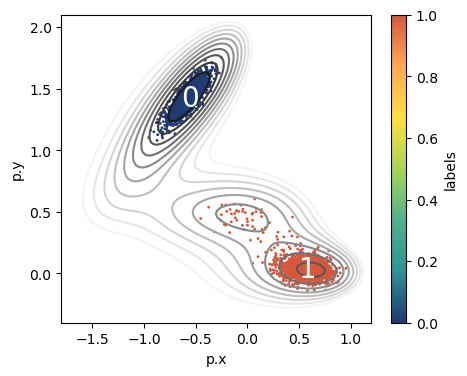

In [4]:
fig,ax = plt.subplots(figsize=(5,4),dpi=100)
# ploy MB isolines
plot_isolines_2D(muller_brown_potential,mode='contour',levels=np.linspace(0,24,12),ax=ax)
# plot points colored according to labels
df.plot.scatter('p.x','p.y',c='labels',s=1,cmap='fessa',ax=ax)
# draw state labels
for i in range(n_states):
    df_g = df.groupby('labels').mean()
    ax.text(x = df_g['p.x'].values[i]-0.075, 
            y = df_g['p.y'].values[i]-0.075,
            s = str(i), size=20, color='white')


Prepare dataset

In [4]:
# get inputs X and labels
X = dataset[:]['data']
labels = dataset[:]['labels']

print('X:',X.shape)
print('labels:',labels.shape)

X: torch.Size([4002, 2])
labels: torch.Size([4002])


### Linear Discriminant Analysis

In [5]:
from mlcolvar.core.stats import LDA

# define LDA object 
lda = LDA(in_features=X.shape[1], n_states=n_states, mode='standard')

# compute vectors that most discriminate the states
eigvals, eigvecs = lda.compute(X,labels)

#### Visualize CV isolines

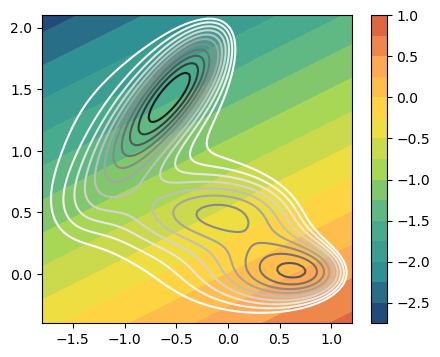

In [7]:
# Inspect linear combination vs potential
n_components=n_states-1
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(lda, component=i, levels=15, ax=ax)

### Harmonic version: HLDA

In [8]:
# define HLDA object 
hlda = LDA(in_features=X.shape[1], n_states=n_states, mode='harmonic')

# compute vectors that most discriminate the states
eigvals, eigvecs = hlda.compute(X,labels)

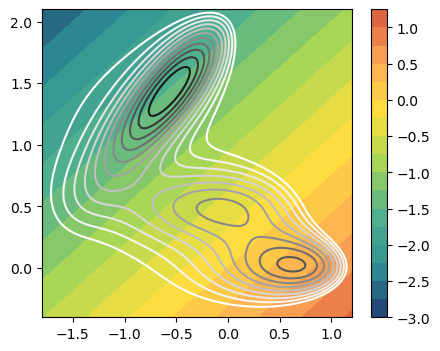

In [9]:
# Inspect linear combination vs potential
n_components=n_states-1
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(hlda, component=i, levels=15, ax=ax)

### Deep-LDA: maximizing LDA eigenvalues

#### Create datamodule

In [10]:
# create datamodule for trainere
datamodule = DictionaryDataModule(dataset,lengths=[0.8,0.2])
datamodule

Class 0 dataframe shape:  (2001, 12)
Class 1 dataframe shape:  (2001, 12)

 - Loaded dataframe (4002, 12): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'labels']
 - Descriptors (4002, 2): ['p.x', 'p.y']


DictionaryDataModule(dataset -> DictionaryDataset( "data": [4002, 2], "labels": [4002] ),
		     train_loader -> FastDictionaryLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> FastDictionaryLoader(length=0.2, batch_size=0, shuffle=True))

#### Define model

In [11]:
from mlcolvar.cvs import DeepLDA

n_components = n_states-1
nn_layers = [2,30,30,5]
nn_args = {'activation': 'relu'}
options= {'nn': nn_args}
# MODEL
model = DeepLDA(nn_layers,n_states=n_states)

#### Define Trainer & Fit

In [12]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_eigval_1_epoch", mode='max', min_delta=1e-3, patience=20)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | norm_in | Normalization | 0      | [2]      | [2]      
1 | nn      | FeedForward   | 1.2 K  | [2]      | [5]      
2 | lda     | LDA           | 0      | [5]      | [1]      
-------------

Epoch 696: 100%|██████████| 2/2 [00:00<00:00, 150.82it/s, loss=-62.7]       


Learning curve

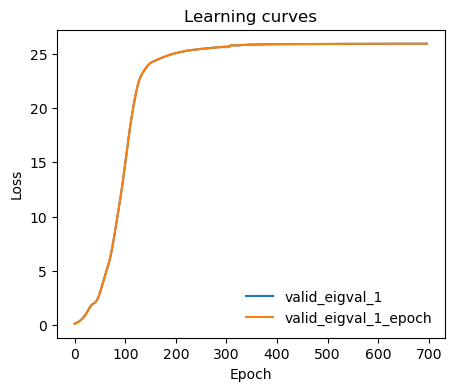

In [13]:
ax = plot_metrics(metrics.metrics, 
                  keys=[x for x in  metrics.metrics.keys() if 'valid_eigval' in x],#['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

#### Analysis of the CV

CVs isolines

Text(0.5, 1.0, 'DeepLDA')

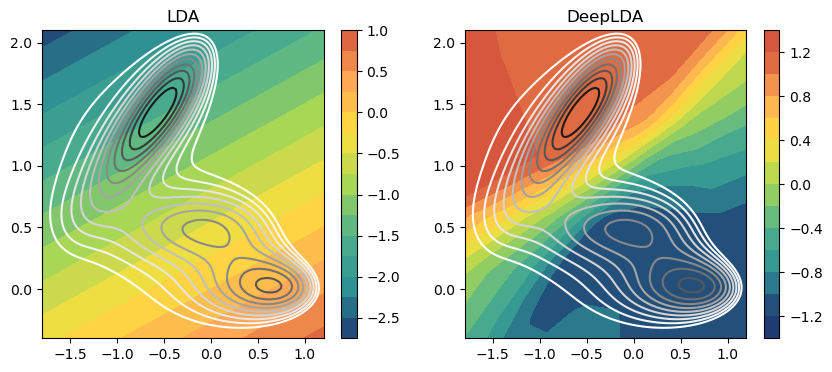

In [14]:
fig,axs = plt.subplots( 1, 2, figsize=(5*2,4) )

# LDA
ax = axs[0]
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
plot_isolines_2D(lda, component=i, levels=15, ax=ax)
ax.set_title('LDA')

# Deep-LDA
ax = axs[1]
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
plot_isolines_2D(model, component=i, levels=15, vmin=-1.2,vmax=1.2, ax=ax)
ax.set_title('DeepLDA')

CVs histogram

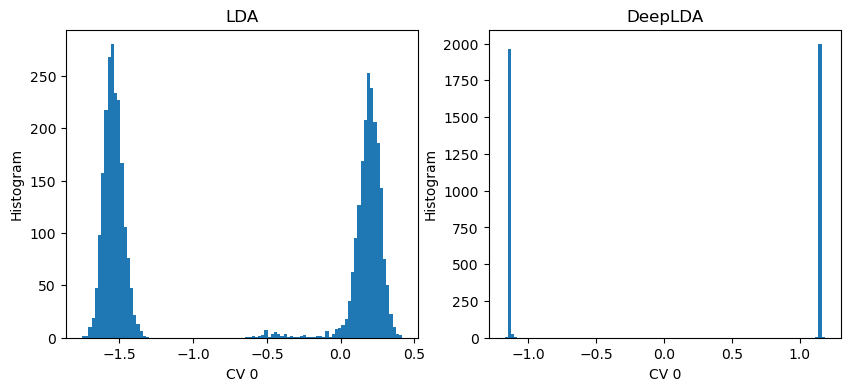

In [18]:
fig,axs = plt.subplots( 1, 2, figsize=(5*2,4) )

titles = ['LDA','DeepLDA']

for (m, ax, title) in zip([lda,model],axs,titles):

    X = dataset[:]['data']
    with torch.no_grad():
        s = m(torch.Tensor(X)).numpy()

    ax.hist(s[:,0],bins=100)
    ax.set_xlabel(f'CV {i}')
    ax.set_ylabel('Histogram')
    ax.set_title(title)

## Deep-LDA on alanine dipeptide

#### Load data

We use the alanine dipeptide simulation data from the [PLUMED-MASTERCLASS](https://github.com/luigibonati/masterclass-plumed/) repository.

In [24]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictionaryDataModule

filenames = [ "https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sA/COLVAR", 
              "https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sB/COLVAR" ]

n_states = len(filenames)

# load dataset
dataset, df = create_dataset_from_files(filenames,
                                        filter_args={'regex':'d_' }, # select distances between heavy atoms
                                        create_labels=True,
                                        return_dataframe=True, 
                                        )

datamodule = DictionaryDataModule(dataset,lengths=[0.8,0.2])

Class 0 dataframe shape:  (5001, 53)
Class 1 dataframe shape:  (5001, 53)

 - Loaded dataframe (10002, 53): ['time', 'phi', 'psi', 'theta', 'xi', 'ene', 'd_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd_11_15', 'd_11_16', 'd_11_17', 'd_11_19', 'd_15_16', 'd_15_17', 'd_15_19', 'd_16_17', 'd_16_19', 'd_17_19', 'walker', 'labels']
 - Descriptors (10002, 45): ['d_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd_11_15

Inspect Inputs

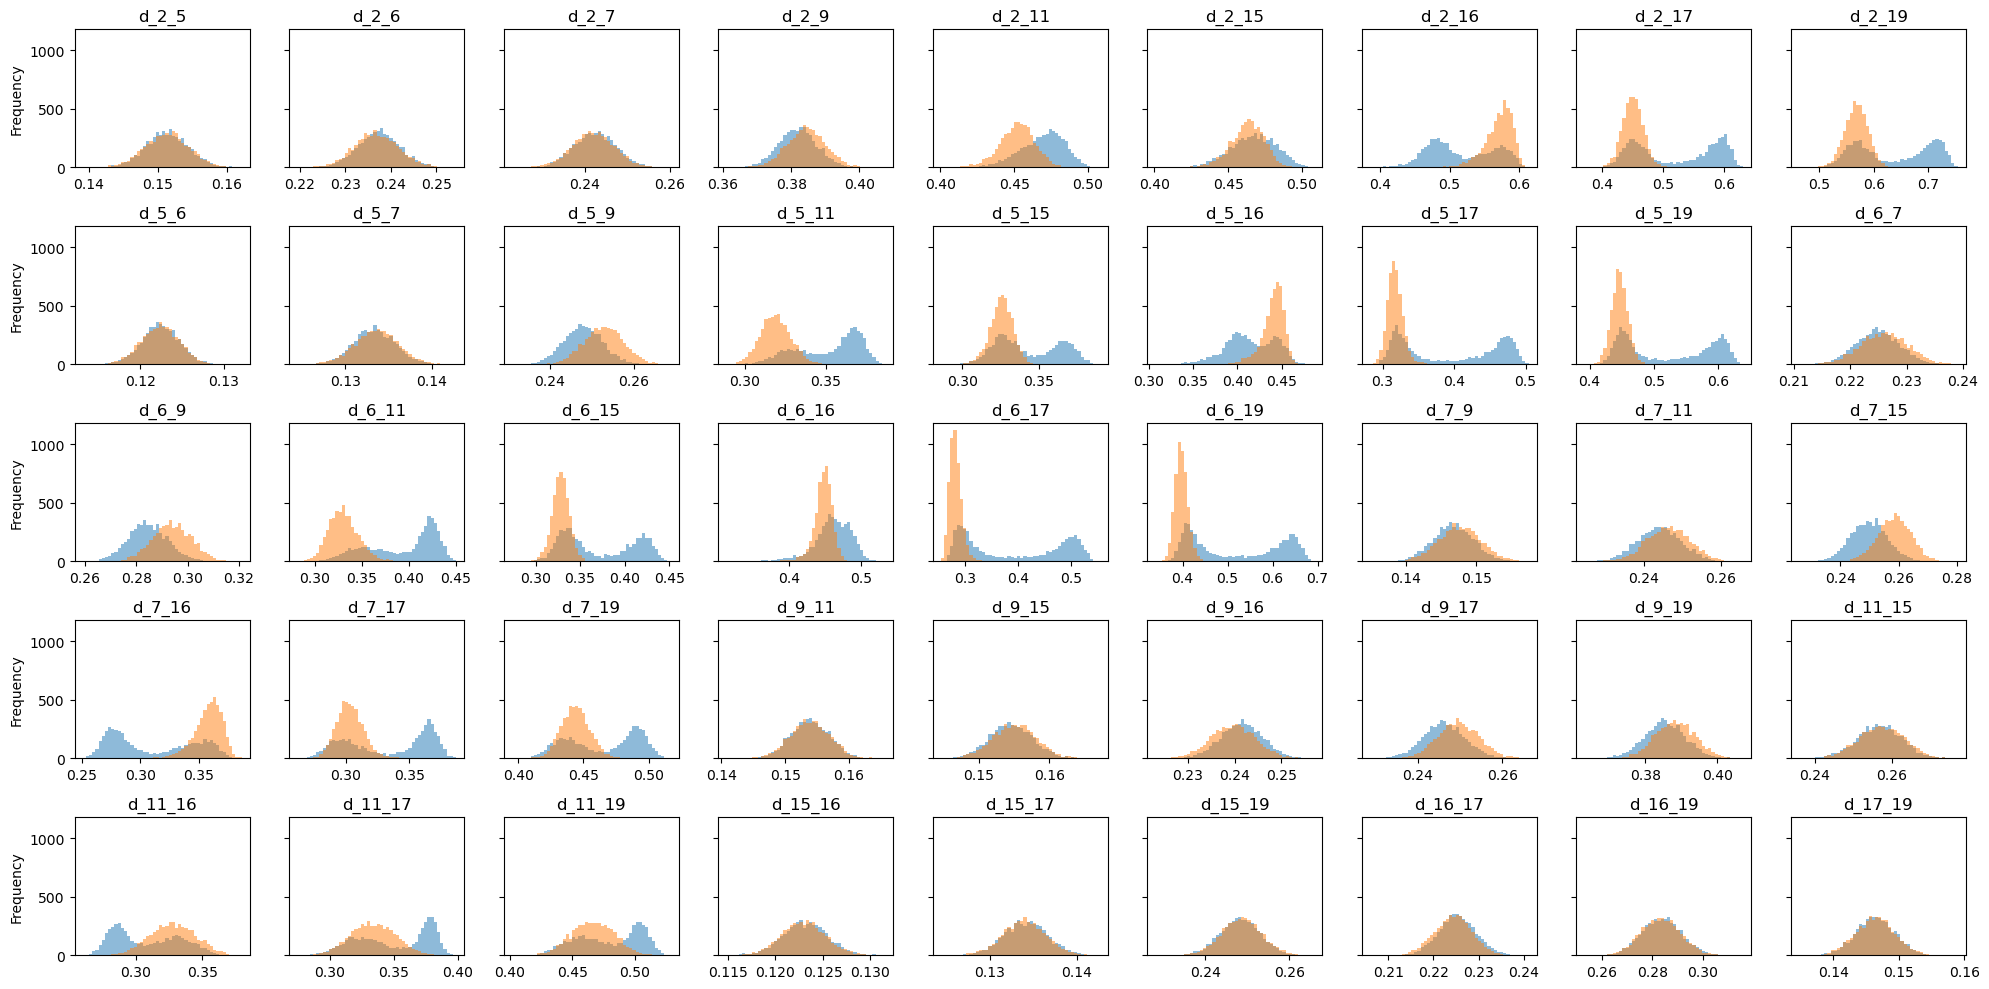

In [34]:
descriptors_names = df.filter(regex='d_').columns.values

fig,axs = plt.subplots(5,9,figsize=(20,10),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    df.pivot(columns='labels')[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False)
    ax.set_title(desc)

plt.tight_layout()

### Train DeepLDA 

Define CV

In [25]:
from mlcolvar.cvs import DeepLDA

n_input           = dataset['data'].shape[-1]
nodes             = [n_input,30,30,2]
# MODEL
model = DeepLDA(nodes, n_states=n_states)

model

DeepLDA(
  (norm_in): Normalization(in_features=45, out_features=45, mode=mean_std)
  (nn): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=45, out_features=30, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=30, out_features=30, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=30, out_features=2, bias=True)
    )
  )
  (lda): LDA(in_features=2, out_features=1)
)

Define trainer and fit

In [26]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=0.1, patience=50)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | norm_in | Normalization | 0      | [45]     | [45]     
1 | nn      | FeedForward   | 2.4 K  | [45]     | [2]      
2 | lda     | LDA           | 0      | [2]      | [1]      
-------------

Epoch 307: 100%|██████████| 2/2 [00:00<00:00, 134.71it/s, loss=-62.5]       


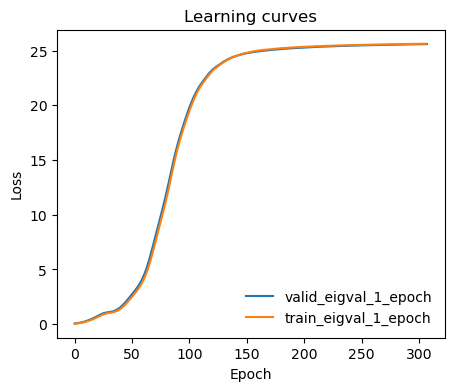

In [31]:
ax = plot_metrics(metrics.metrics, 
                  keys=[x for x in  metrics.metrics.keys() if 'eigval' in x and 'epoch' in x],#['train_loss_epoch','valid_loss'],
                  yscale='linear')

#### CV analysis

In [36]:
# evaluate cv on training set and append to dataframe
X = dataset[:]['data']
model.eval()
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

n_components = n_states-1

for i in range(n_components):
    df[f'CV{i}'] = s[:,i] 

Histogram

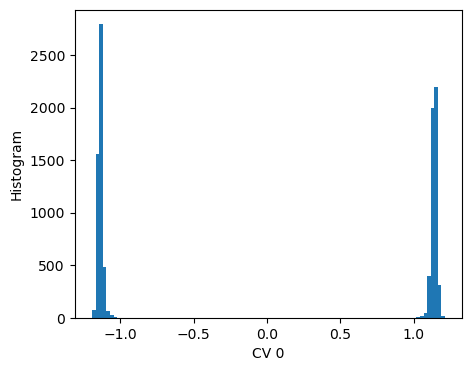

In [37]:
fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    ax.hist(s[:,i],bins=100)
    ax.set_xlabel(f'CV {i}')
    ax.set_ylabel('Histogram')

View isolines in physical space

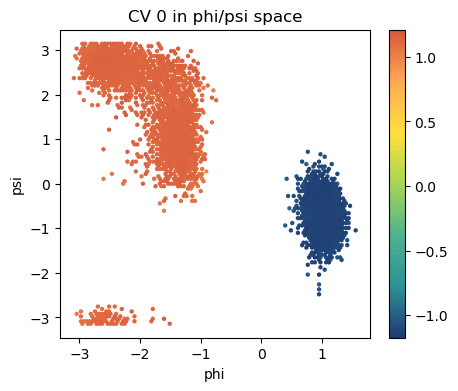

In [40]:
n_components = n_states-1

fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    df.plot.hexbin('phi','psi',C=f'CV{i}',cmap='fessa',ax=ax)
    ax.set_title(f'CV {i} in phi/psi space')